<a href="https://colab.research.google.com/github/HeeminYang/Study_Hondson_ml3/blob/main/part17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**17장 – 오토인코더와 GAN**

_이 노트북은 17장에 있는 모든 샘플 코드를 담고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [3]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

fashion MNIST 데이터셋을 사용합니다:

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

# 적층 오토인코더

# 밀집 층 대신에 합성곱 층 사용하기

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만들어 보겠습니다.

**이미지를 다루는 경우**에는 (이미지가 매우 작지 않다면) **오토인코더가 좋은 성능을 내지 못합니다.**     
14장에서 본 것처럼 **이미지를 다룰 때는 합성곱** 신경망이 밀집 네트워크보다 훨씬 잘 맞습니다.     
따라서 (비지도 사전훈련이나 차원 축소를 위해) 이미지에 대한 오토인코더를 만들려면 합성곱 오토인코더를 만들어야 합니다.     
인코더는 합성곱 층과 풀링 층으로 구성된 일반적인 CNN입니다.    
인코더는 전형적으로 입력에서 공간 방향의 차원(즉, 높이와 너비)를 줄이고 깊이(즉, 특성 맵의 개수)를 늘립니다.       
디코더는 거꾸로 동작해야 합니다(이미지의 스케일을 늘리고 깊이를 원본 차원으로 되돌려야 합니다).       
이를 위해서 전치 합성곱 층 `Conv2DTranspose()`을 사용합니다(또는 합성곱 층과 업샘플링 층을 연결할 수 있습니다).      
다음은 패션 MNIST 데이터셋에 대한 간단한 합성곱 오토인코더입니다. 

In [6]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 25s 7ms/step - loss: 0.3006 - rounded_accuracy: 0.9198 - val_loss: 0.2819 - val_rounded_accuracy: 0.9341
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2750 - rounded_accuracy: 0.9418 - val_loss: 0.2723 - val_rounded_accuracy: 0.9463
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2706 - rounded_accuracy: 0.9462 - val_loss: 0.2712 - val_rounded_accuracy: 0.9456
Epoch 4/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2681 - rounded_accuracy: 0.9488 - val_loss: 0.2683 - val_rounded_accuracy: 0.9496
Epoch 5/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2663 - rounded_accuracy: 0.9507 - val_loss: 0.2666 - val_rounded_accuracy: 0.9518


In [7]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          1

1/1 [==============================] - 0s 240ms/step


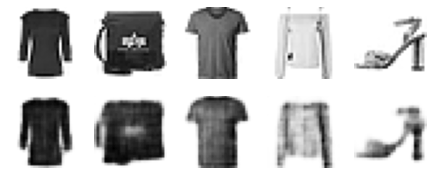

In [8]:
show_reconstructions(conv_ae)
plt.show()

# 순환 오토인코더

(비지도 학습이나 차원 축소를 위해) **시계열이나 텍스트**와 같은 시퀀스에 대한 오토인코더를 만들려면 **순환 신경망(RNN, LSTM)**이 밀집 네트워크보다 더 나을 수 있습니다.   
순환 인코더는 쉽게 만들 수 있습니다.    
인코더는 일반적으로 입력 시퀀스를 하나의 벡터로 압축하는 squence-to-vector RNN입니다.   
디코더는 반대로 vector-to-squence RNN입니다.   
이 순환 오토인코더는 타임 스텝마다 28차원을 갖는 어떤 길이의 시퀀스로 처리할 수 있습니다.    
편리하게도 이 말은 각 이미지를 행의 시퀀스로 간주하여 패션 MNIST 이미지를 처리할 수 있다는 뜻입니다.    
각 타임 스텝에서 이 RNN은 28픽셀의 행 하나를 처리합니다.     
당연히 어떤 종류의 시퀀스에도 순환 오토인코더를 사용할 수 있습니다.    
타임 스텝마다 입력 벡터를 주입하기 위해 디코더의 첫 번째 층에 RepeatVector 층을 사용한 점을 주목하세요.    

In [9]:
recurrent_encoder = keras.models.Sequential([ # squence-to-vector RNN
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([ # vector-to-squence RNN
    keras.layers.RepeatVector(28, input_shape=[30]), # 타임 스텝마다 입력 벡터를 주입
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [20]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 26s 12ms/step - loss: 0.5014 - rounded_accuracy: 0.7647 - val_loss: 0.4337 - val_rounded_accuracy: 0.8229
Epoch 2/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3933 - rounded_accuracy: 0.8496 - val_loss: 0.3709 - val_rounded_accuracy: 0.8695
Epoch 3/10
1719/1719 [==============================] - 23s 13ms/step - loss: 0.3598 - rounded_accuracy: 0.8747 - val_loss: 0.3541 - val_rounded_accuracy: 0.8792
Epoch 4/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3454 - rounded_accuracy: 0.8846 - val_loss: 0.3475 - val_rounded_accuracy: 0.8822
Epoch 5/10
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3360 - rounded_accuracy: 0.8914 - val_loss: 0.3326 - val_rounded_accuracy: 0.8937
Epoch 6/10
1719/1719 [==============================] - 20s 12ms/step - loss: 0.3295 - rounded_accuracy: 0.8958 - val_loss: 0.3304 - val_rounded_accuracy: 0.8967
Epoch 7/10
1719/1719 [======

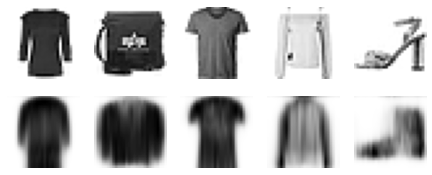

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

# 과대완전 인코더

과소완전: 내부 표현이 입력데이터보다 저차원   
과대완전: 입력크기 만큼, 입력 크기보다 큰 코딩 층을 둠    

# 적층 잡음 제거 오토인코더

오토인코더가 유용한 특성을 학습하도록 강제하는 다른 방법은 입력에 잡음을 추가하고, 잡음이 없는 원본 입력을 복원하도록 훈련하는 것입니다. 이 아이디어는 1980년대부터 있었습니다(얀 르쿤의 1987년 석사논문,,).    
파스칼 빈센트 등이 2008년 논문에서 오토인코더를 특성 추출기로 사용할 수도 있음을 보였습니다.    
파스칼 빈센트 등은 2010년 논문에서 적층 잡음 제거 오토인코더를 소개했습니다.   
잡음은 입력에 추가된 순수한 가우시안 잡음이거나(11장에서 소개한) 드롭아웃처럼 무작위로 입력을 꺼서 발생시킬 수도 있습니다.

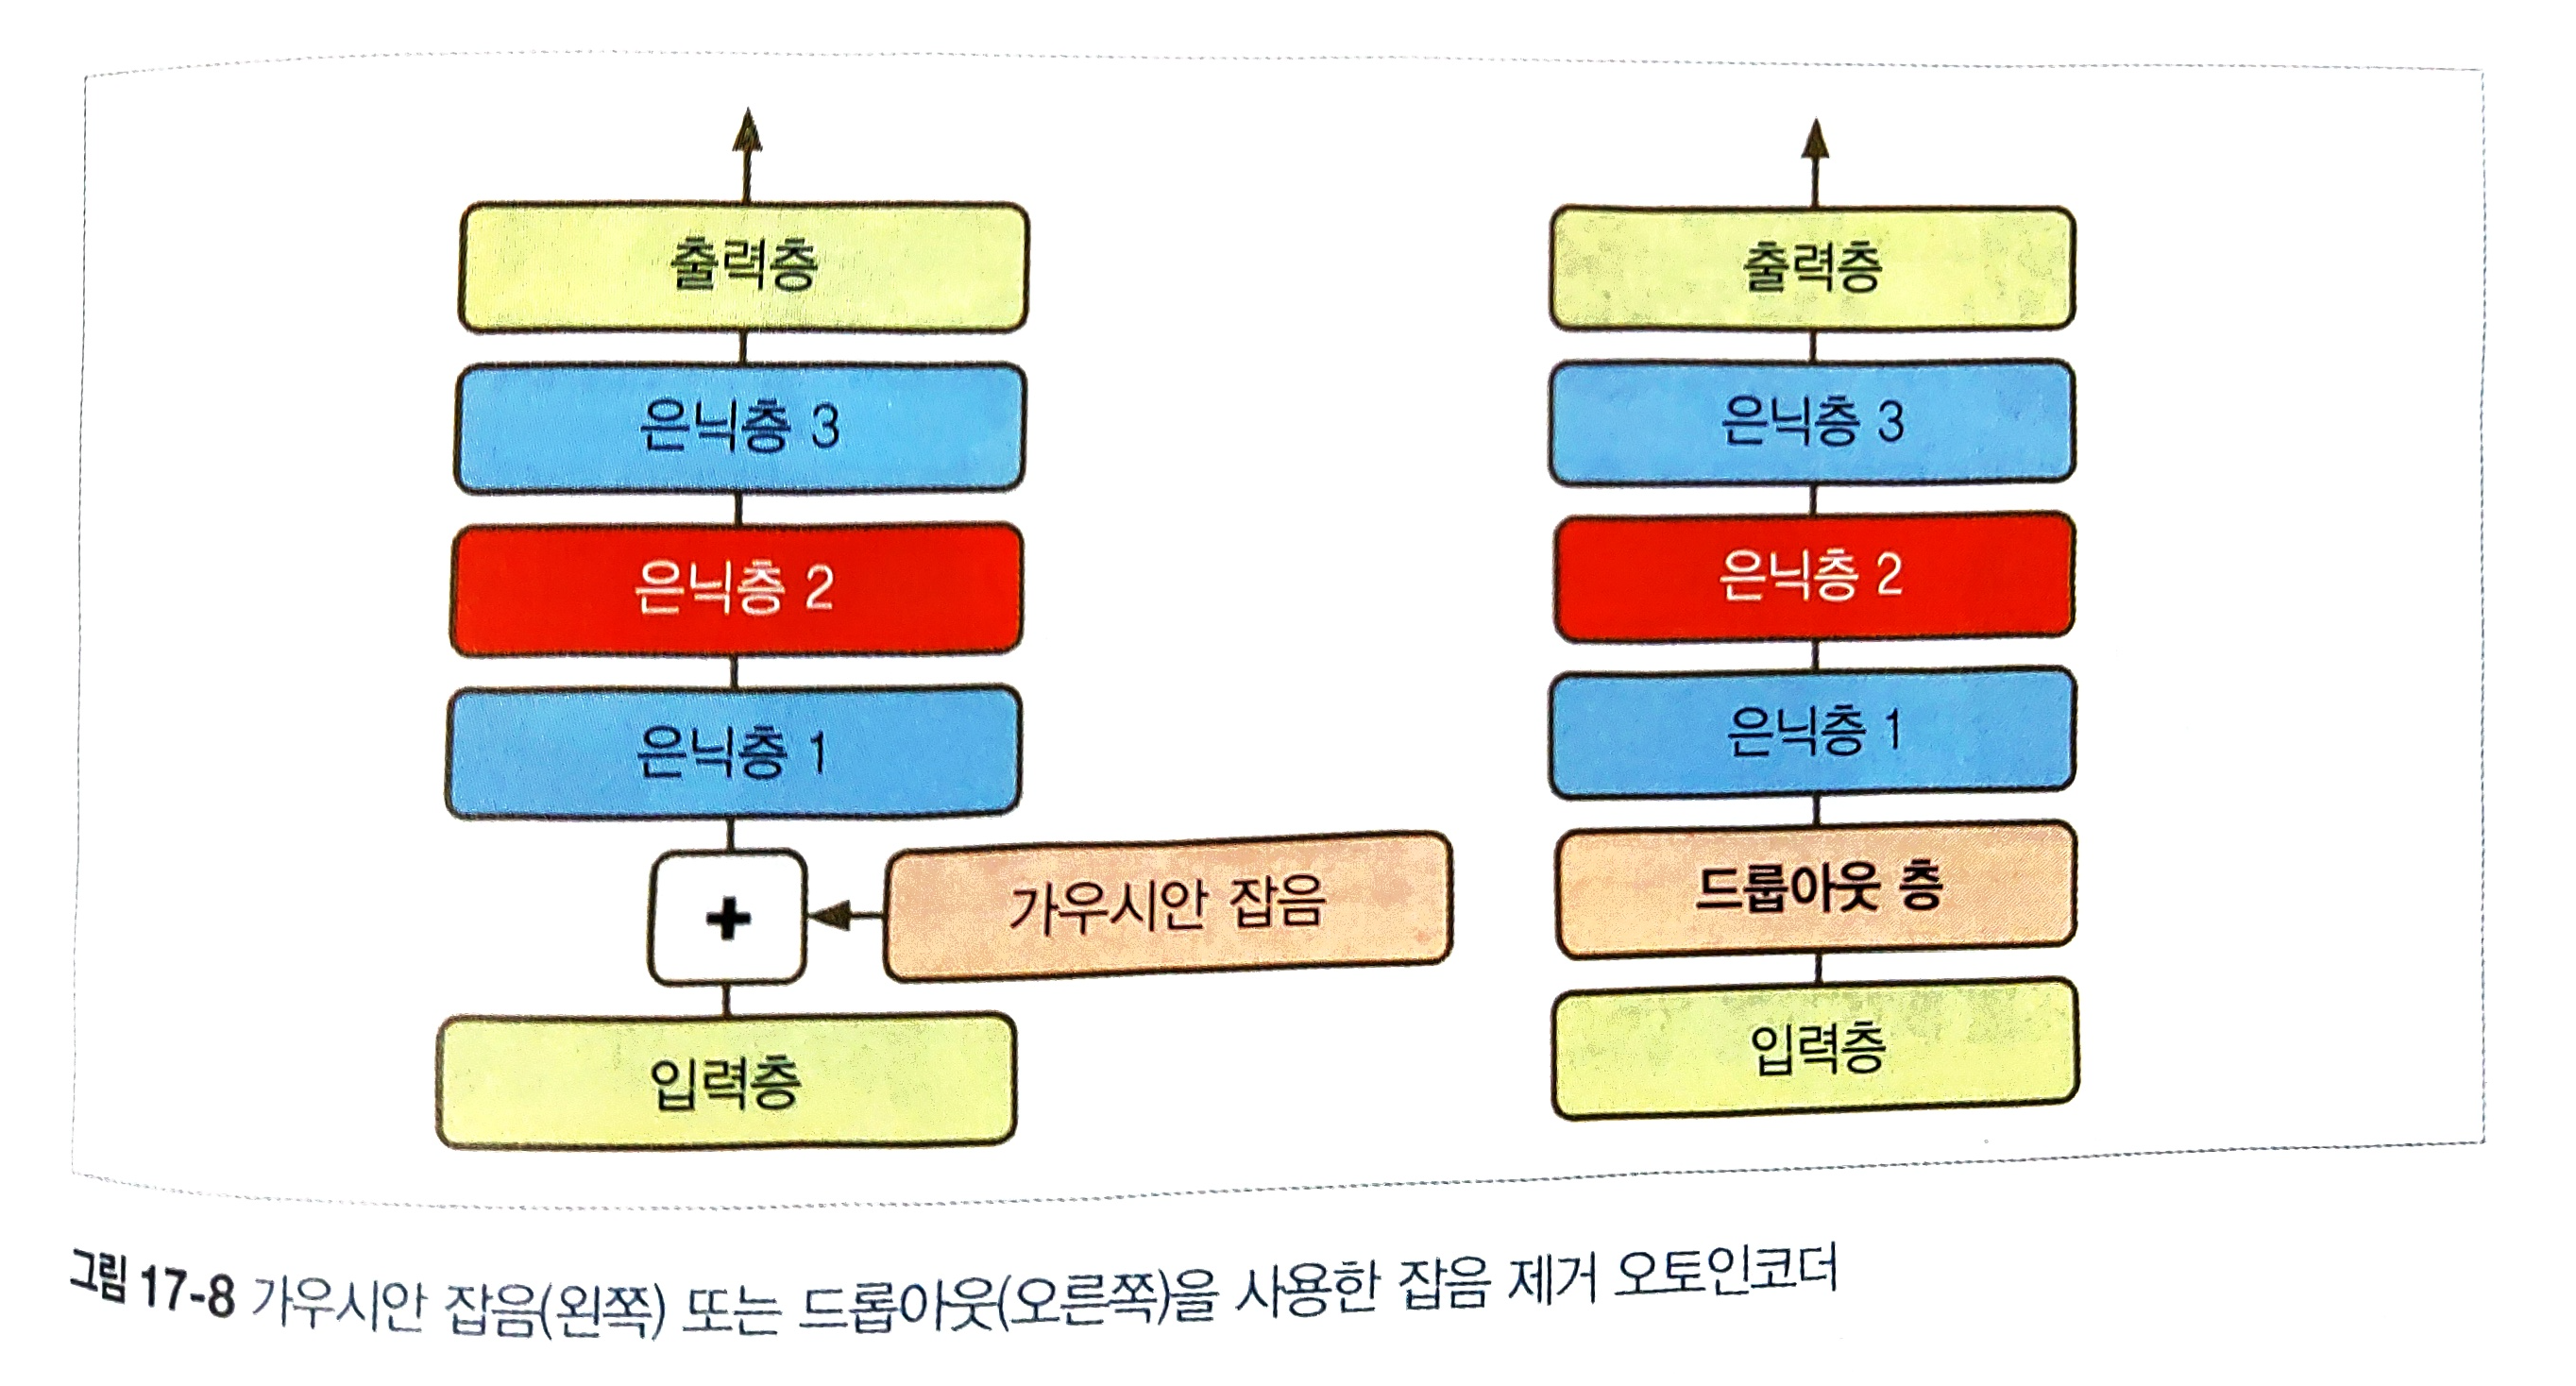

가우시안 잡음을 사용합니다:

In [21]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2), # 가우시안 노이즈
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3489 - rounded_accuracy: 0.8784 - val_loss: 0.3178 - val_rounded_accuracy: 0.9056
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3125 - rounded_accuracy: 0.9093 - val_loss: 0.3090 - val_rounded_accuracy: 0.9154
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3062 - rounded_accuracy: 0.9147 - val_loss: 0.3044 - val_rounded_accuracy: 0.9152
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3026 - rounded_accuracy: 0.9179 - val_loss: 0.3005 - val_rounded_accuracy: 0.9213
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2998 - rounded_accuracy: 0.9203 - val_loss: 0.2979 - val_rounded_accuracy: 0.9239
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2978 - rounded_accuracy: 0.9221 - val_loss: 0.2961 - val_rounded_accuracy: 0.9259
Epoch 7/10
1719/1719 [=================

위: 잡음 섞인 이미지    
아래: 재구성된 이미지

1/1 [==============================] - 0s 78ms/step


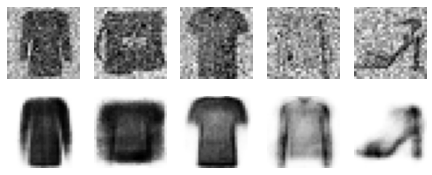

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

드롭아웃을 사용합니다:

In [23]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5), # 드랍아웃
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3530 - rounded_accuracy: 0.8744 - val_loss: 0.3197 - val_rounded_accuracy: 0.9052
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3183 - rounded_accuracy: 0.9030 - val_loss: 0.3118 - val_rounded_accuracy: 0.9115
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3125 - rounded_accuracy: 0.9077 - val_loss: 0.3068 - val_rounded_accuracy: 0.9151
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3087 - rounded_accuracy: 0.9107 - val_loss: 0.3043 - val_rounded_accuracy: 0.9184
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3061 - rounded_accuracy: 0.9129 - val_loss: 0.3011 - val_rounded_accuracy: 0.9201
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3041 - rounded_accuracy: 0.9146 - val_loss: 0.3003 - val_rounded_accuracy: 0.9188
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 80ms/step
그림 저장 dropout_denoising_plot


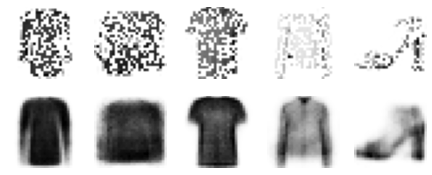

In [24]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# 희소 오토인코더

좋은 특성을 추출하도록 만드는 다른 제약의 방식은 **희소(Sparsity)**입니다. 이는 **비용함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화되는 뉴런 수를 감소**시키도록 만듭니다. 


예를 들어 **코딩 층에서 평균적으로 5% 뉴런만 활성화되도록 강제**할 수 있습니다.    
이렇게 하면 오토인코더가 **적은 수의 활성화된 뉴런을 조합하여 입력을 표현**해야 합니다.    
결국 코딩 층의 각 뉴런은 **유용한 특성을 표현**하게 됩니다(만약 여러분이 한 달에 몇 마디 말만 할 수 있다면 꼭 필요한 말만 할 것입니다).

간단한 방법은 코딩 층에 (코딩을 0과 1 사이 값으로 제한하기 위해) 시그모이드 활성화 함수를 사용하고 큰 코딩 층 (예를 들면 300개의 유닛을 가진 층)을 사용하는 것입니다. 코딩 층의 활성화 값에 $\ell_1$ 규제를 추가합니다(디코더는 일반적인 디코더입니다).


간단한 적층 오토인코더를 만들어 희소 오토인코더와 비교하겠습니다. 이번에는 코딩 층에 시그모이드 활성화 함수를 사용하여 코딩 값의 범위가 0~1 사이가 되도록 만듭니다:

In [ ]:
# 적층 오토인코더
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"), # 시그모이드 활성화 함수를 사용하여 코딩 값의 범위가 0~1 사이가 되도록
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"), 
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8992
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3213 - rounded_accuracy: 0.9012 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

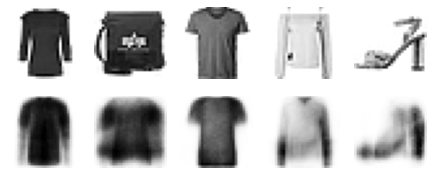

In [ ]:
show_reconstructions(simple_ae)
plt.show()

활성화 히스토그램을 출력하기 위한 함수를 만듭니다:

In [ ]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [ ]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

이 함수를 사용해 인코딩 층의 활성화에 대한 히스토그램을 출력해 보죠. 왼쪽의 히스토그램은 전체 활성화의 분포를 보여줍니다. 0과 1에 가까운 값이 전체적으로 더 많이 등장합니다. 이는 시그모이드 함수가 포화되는 특성 때문입니다. 오른쪽의 히스토그램은 평균 뉴런의 분포를 보여줍니다. 대부분의 뉴런이 0.5에 가까운 평균 활성화를 가지고 있습니다. 두 히스토그램은 각 뉴런이 50% 확률로 0이나 1에 가까운 값에 활성화된다는 것을 보여줍니다. 하지만 일부 뉴런은 거의 항상 활성화됩니다(오른쪽 히스토그램의 오른쪽편).

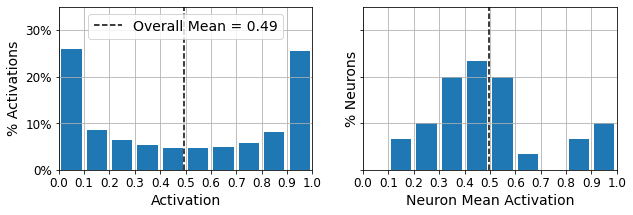

In [ ]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

코딩 층에 $\ell_1$ 규제를 추가해 보죠:

In [ ]:
# 희소 오토인코더
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # 대신해서 Dense에 인자로 activity_regularizer=keras.regularizers.l1(1e-3)를 이전층에 추가해도 된다.
                                                  # 입력을 그대로 반환하면서 훈련 손실에 입력의 절댓값의 합을 더합니다(이 층은 훈련하는 동안에만 작동).
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

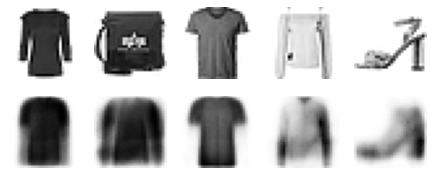

In [ ]:
show_reconstructions(sparse_l1_ae)

이 규제는 신경망이 0에 가까운 코딩을 만들도록 유도하지만 입력을 올바르게 재구성하지 못하면 벌칙을 받기 때문에 적어도 0이 아닌 값이 조금은 출력되어야 합니다.   

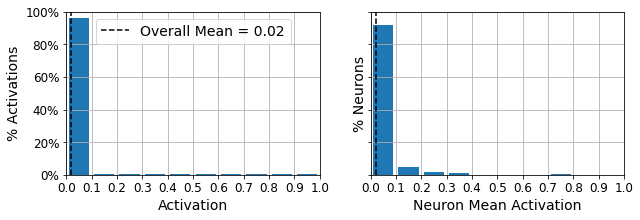

In [ ]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()
# 좌: 코딩 층에 있는 모든 활성화의 분포
# 우: 각 뉴런의 평균 활성화 분포

또 다른 방법은 훈련 반복마다 코딩 층의 실제 희소 정도를 측정하고 측정된 희소 정도가 타깃 희소 정도와 다르면 모델에 벌칙을 부과하는 것입니다.   
이를 위해 전체 훈련 배치에 대해 코딩 층에 있는 각 뉴런의 평균적인 활성화를 계산합니다.   
배치크기는 너무 작지 않아야 합니다.   
그렇지 않으면 평균값이 정확하지 않을 것입니다.

**각 뉴런에 대한 평균 활성화 정도를 알면 비용 함수에 희소 손실을 추가하여 너무 활성화되거나 충분히 활성화되지 않은 뉴런에 벌칙을 가할 수 있습니다.**    
예를 들어 한 뉴런의 평균 활성화가 0.3이고 목표 희소 정도가 0.1이라면, 이 뉴런은 덜 활성화되도록 규제해야 합니다.   
간단한 방법은 비용 함수에 제곱 오차 (0.3-0.1)$^2$을 추가하는 것입니다.   


하지만 실전에서 더 좋은 방법은 [그림 17-10]에서 볼 수 있듯이 평균 제곱 오차(MSE)보다 훨씬 강한 그레디언트를 가진 쿨백-라이블러 발산(4장)을 사용하는 것입니다.


Saving figure sparsity_loss_plot


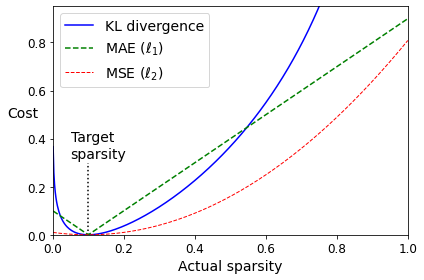

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="쿨백-라이블러 발산")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("실제 희소 정도")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

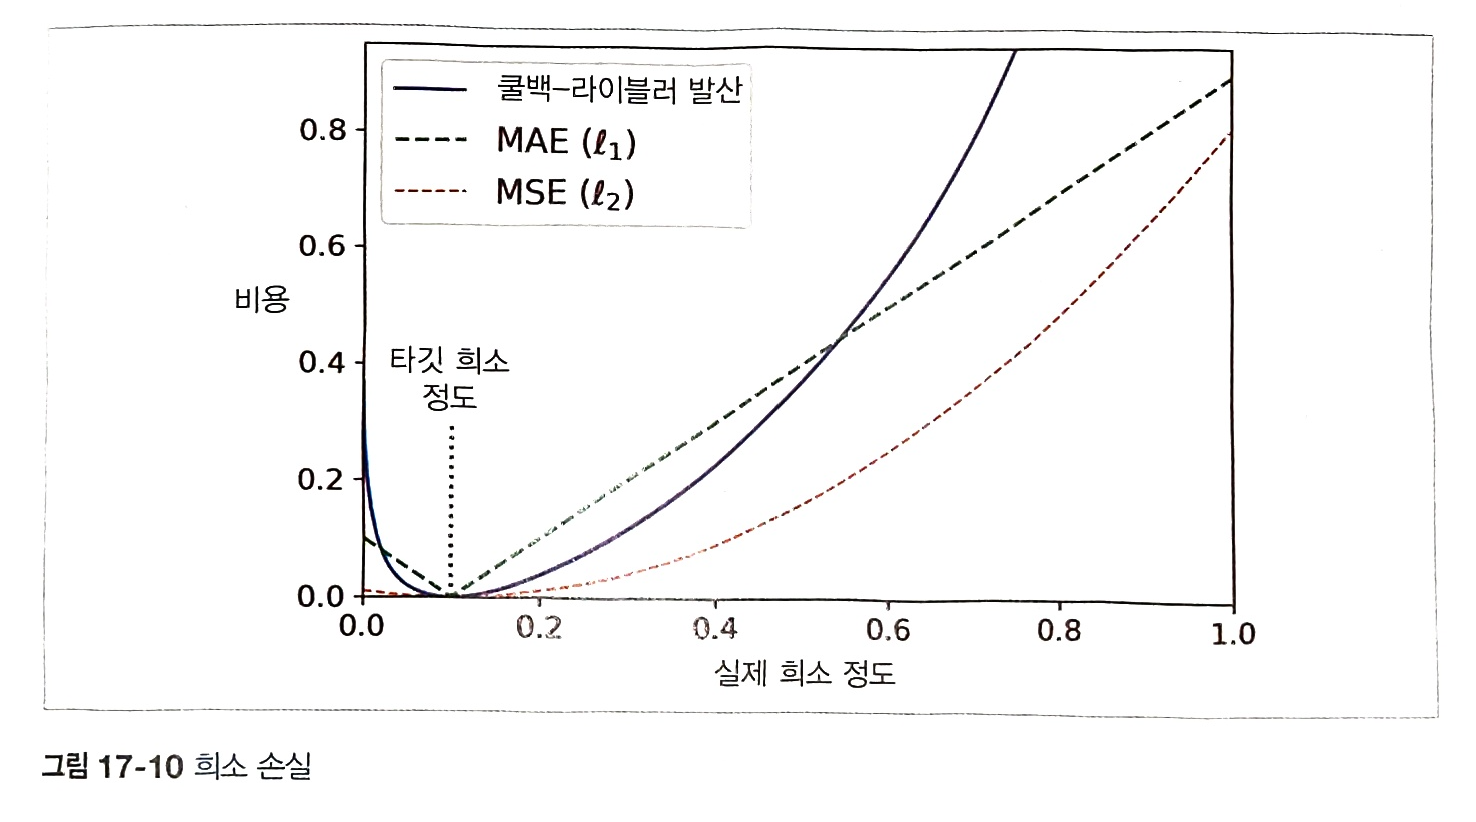

두개의 이산 확률 분포 $P$와 $Q$가 주어졌을 때, 이 두 분산 사이의 KL발산 $D_{𝙺𝙻}(P||Q)$는 [식 17-1]을 사용해 계산할 수 있습니다.

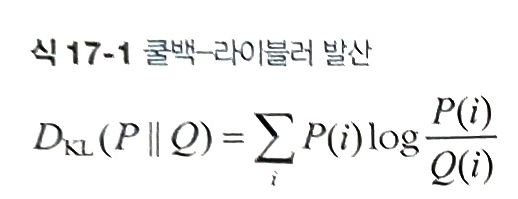

여기에서는 코딩 층에서 뉴런이 활성화 될 목표 확률 $p$와 실제 확률 $q$(즉, 훈련 배치에 대한 평균 활성화) 사이의 발산을 측정합니다. 그러므로 KL발산은 [식 17-2]와 같이 간단해집니다.

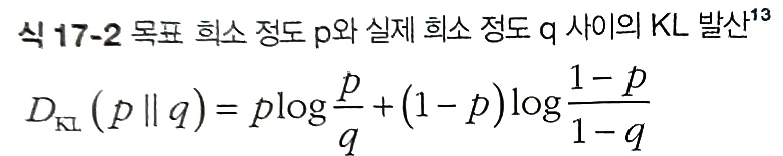

희소성을 위해 KL 발산을 사용하여 0% 아니라 10% 희소성을 만들어 보죠:

코딩 층의 각 뉴런에 대해 희소 손실을 계산했다면, 이 손실들을 모두 합해서 비용 함수의 결과에 더합니다.   
희소 손실과 재구성 손실의 상대적 중요도를 제어하기 위해 희소 손실에 희소 가중치 하이퍼파라미터를 곱합니다.   
이 가중치가 너무 크면 모델이 목표 희소에 가깝게 되겠지만 입력을 적절히 재구성하지 못해서 쓸모없는 모델이 될 수 있습니다.   
반대로 가중치가 너무 작으면 모델이 희소 목표를 거의 무시할 것이므로 어떤 흥미로운 특성도 학습하지 못할 것입니다.

KL 발산을 기반으로 하는 희소 오토인코더를 구현하기 위해 필요한 모든 것을 배웠습니다. 먼저 KL 발산 규제를 적용하기 위해 사용자 정의 규제를 만들어보죠.

In [ ]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

코딩 층의 활성화에 KLDivergenceRegularizer를 적용해 희소 오토인코더를 만듭니다.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

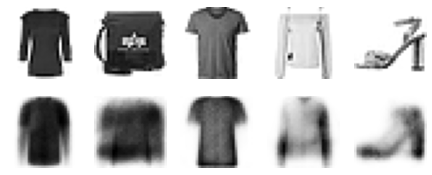

In [ ]:
show_reconstructions(sparse_kl_ae)

패션 MNIST에 희소 오토인코더를 훈련한 후 코딩 층에 있는 뉴런의 활성화가 거의 0에 가깝게 되었습니다.(전체 활성화의 약 70%가 0.1보다 작습니다).    
전체 뉴런의 평균 활성화가 0.1 근처입니다(전체 뉴런의 약 90%가 0.1과 0.2 사이의 평균 활성화를 가집니다).

Saving figure sparse_autoencoder_plot


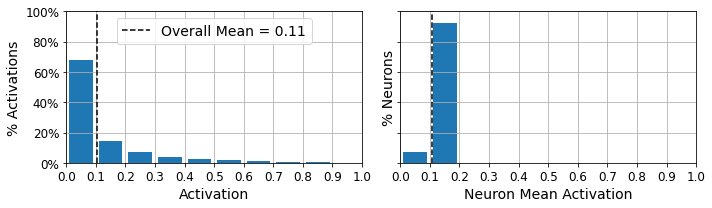

In [ ]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()
# 좌: 코딩 층에 있는 모든 활성화의 분포
# 우: 각 뉴런의 평균 활성화 분포

# 변이형 오토인코더 Variational autoencoder

2014년 다이데릭 킹마 와 맥스웰링이 또 다른 종류의 중요한 오토인코더를 소개했습니다. 그리고 순식간에 가장 인기있는 오토인코더 중 하나가 되었습니다. 바로 **변이형 오토인코더(variational autoencoder)**입니다.   
변이형 오토인코더는 다음과 같은 점에서 지금까지 다룬 오토인코더와 매우 다릅니다.


* **확률적 오토인코더(probablistic sutiencoder)**입니다. 즉 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됩니다(이와는 반대로 잡음제거 오토인코더는 훈련 시에만 무작위성을 사용합니다).
* 무엇보다도 **생성 오토인코더(generative autoencoder)**라는 점이 중요합니다. 마치 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성할 수 있습니다.

이런 두 속성이 변이형 오토인코더를 RBM과 유사하게 만듭니다. 하지만 훈련이 더 쉽고 샘플링 과정이 훨씬 빠릅니다(RBM에서는 새로운 샘플을 만들기 전에 네트워크가 '열평형'상태로 안정될 때까지 기다려야 합니다). 이름에서 알 수 있듯이 변이형 오토인코더는 (9장에서 소개한) 효율적인 근사 베이즈 추론 방법인 변분 베이즈 추론(variational Bayesian inference)을 수행합니다.



RBM: Restricted Boltzmann Machines(Generative Model)   
일반적으로 DNN, CNN, LSTM 등과 같은 Deterministic Model 과는 다른 방식의 접근 방법이다.   
우리가 일반적으로 사용하는 Deterministic Model은 loss function을 '지표'로 활용해 오차를 줄이는 것을 목표로 하지만, Generative Model의 경우 확률밀도함수(probability density function; pdf)를 모델링하는 것을 목표로 삼는다. 

어떻게 작동하는지 살펴보겠습니다. [그림17-12]의 왼쪽은 변이형 오토인코더입니다.    
오토인코더의 기본 구조인 인코더와 그 뒤를 따르는 디코더(이 예에서는 은닉층이 각각 두 개로 구성되었습니다)가 있습니다.    
그런데 다른점이 있습니다.   
주어진 입력에 대한 코딩을 바로 만드는 대신, 인코더는 평균코딩 μ와 표준편차 σ를 만듭니다.   
실제 코딩은 평균이 μ이고 표준편차가 σ인 가우시안 분포에서 랜덤하게 샘플링됩니다.   
그 후 디코더가 샘플링된 코딩을 보통처럼 디코딩합니다.   
오른쪽 그림은 이 오토인코더를 통과하는 훈련 샘플을 보여줍니다.   
**먼저 인코더가 μ와 σ를 만들면 코딩이 랜덤하게 선택됩니다(μ의 위치와 정확히 같지 않습니다).**   
마지막으로 이 코딩이 디코드되어 훈련 샘플을 닮은 최종 출력을 만듭니다.

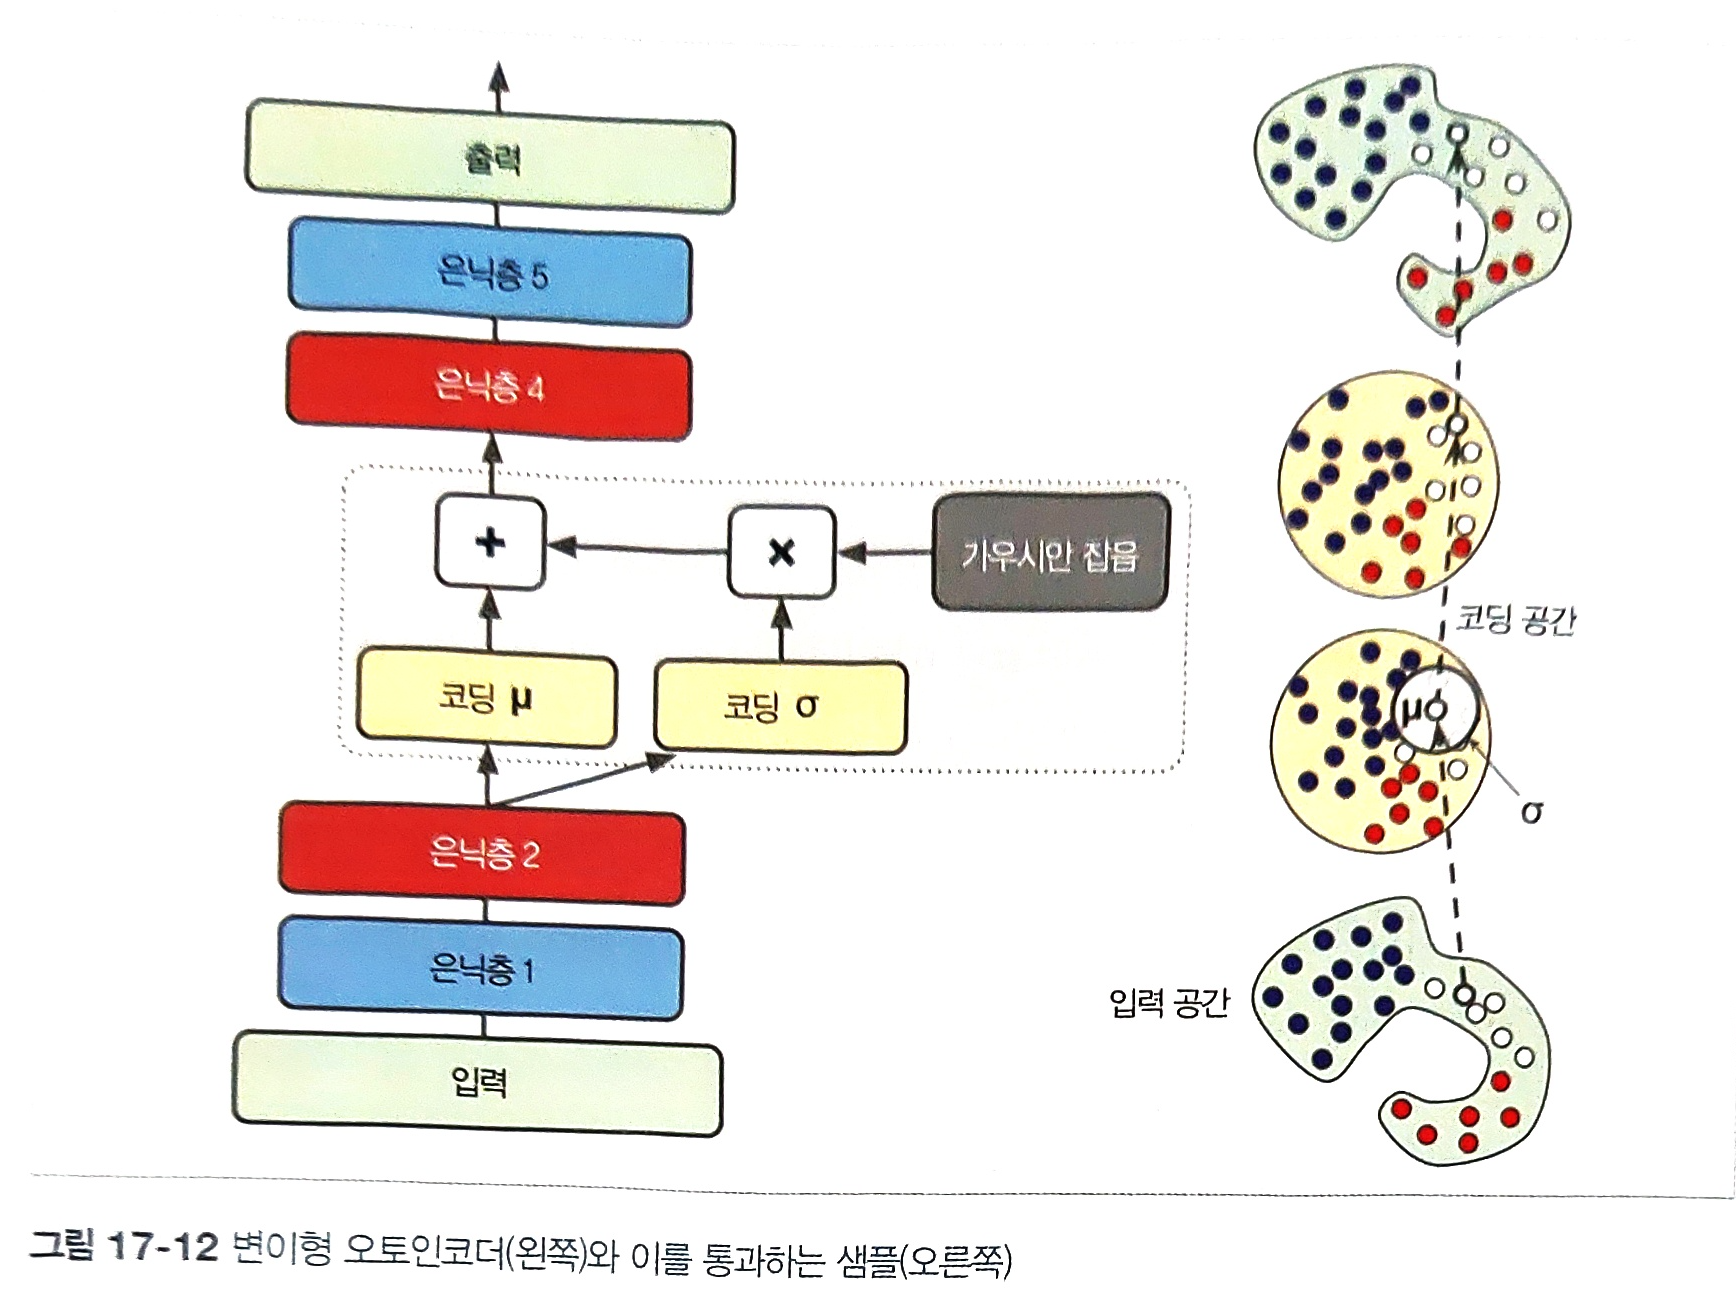

그림에서 볼 수 있듯이 변이형 오토인코더는 입력이 매우 복잡한 분포를 가지더라도 간단한 가우시안(정규) 분포에서 샘플링된 것처럼 보이는 코딩을 만드는 경향이 있습니다.    
훈련하는 동안 비용함수(뒤에서 설명합니다)가 코딩을 가우시안 샘플들의 군집처럼 보이도록 코딩 공간(또는 잠재 공간) 안으로 점직적으로 이동시킵니다.     
그러므로 변이형 오토인코더는 훈련이 끝난 뒤 새로운 샘플을 매우 쉽게 생성할 수 있게 됩니다.     
가우시안 분포에서 랜덤한 코딩을 샘플링해 디코딩하면 됩니다.   

그럼 비용 함수를 알아보겠습니다. 비용 함수는 두 부분으로 구성됩니다.   
첫 번째는 오토인코더가 입력을 재생산하도록 만드는 일반적인 재구성 손실입니다(앞에서 언급한것처럼 이를 위해 크로스 엔트로피를 사용할 수 있습니다).    
두 번째는 단순한 가우시안 분포에서 샘플된 것같은 코딩을 가지도록 오토인코더를 강제하는 잠재 손실입니다.    
여기에는 목표분포(가우시안 분포)와 실제 코딩 분포 사이의 KL 발산을 사용합니다.    
희소 인코더보다 수식이 조금 더 복잡합니다.    
코딩 층으로 전달될 수 있는 정보 양을 제한하는(그래서 오토인코더가 유용한 특성을 학습하게 만드는) 가우시안 잡음 때문에 특히 그렇습니다.    
다행히 이 식을 간소화하여 [식 17-3]으로 잠재 손실을 간단하게 계산할 수 있습니다.

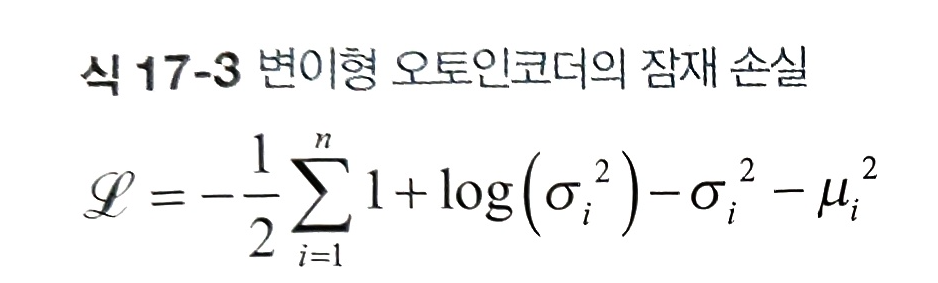

이 식에서는 $𝔏$는 잠재 손실이고 n은 코딩의 차원, $μ_i$와 $\sigma_i$는 i번째 코딩 원소의 평균과 표준편차입니다.     
(모든$μ_i$와 $\sigma_i$를 포함하는) 벡터 μ와 σ는 [그림 17-12]의 왼쪽에 나타난 인코더의 출력입니다.    
**변이형 오토인코더의 구조에서 자주 등장하는 변경 사항은 인코더가 σ가 아니라 γ=log($σ^2$)을 출력하는 것입니다.**    
그럼 잠재 손실은 [식 17-4]처럼 계산할 수 있습니다.   
이 방식이 수학적으로 안정적이고 훈련 속도를 높입니다.

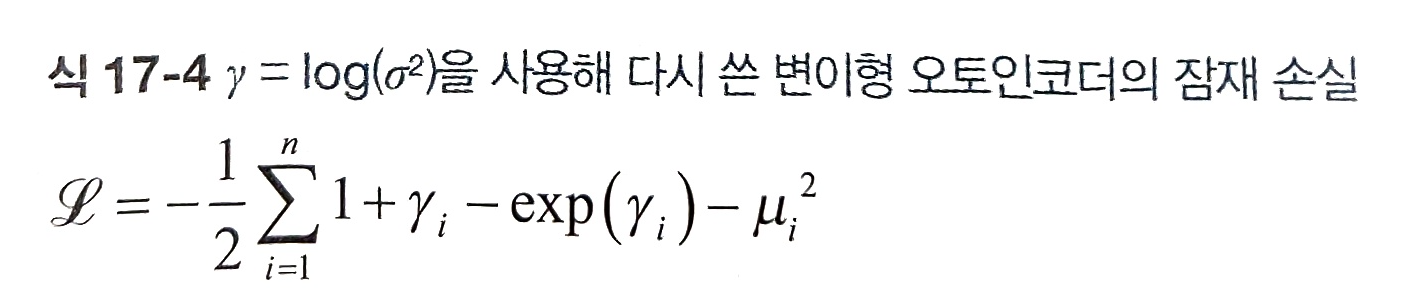

패션 MNIST 데이터셋에서 변이형 오토인코더를 만들어보겠습니다([그림 17-12]에 있는 것과 같지만 γ를 사용합니다). 먼저 μ와 γ가 주어졌을 때 코딩을 샘플링하는 사용자 정의 층이 필요합니다.

In [ ]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

이 `Sampling`층은 두 입력 mean (μ)와 log_var (γ)를 받습니다.    
`K.random_normal()`함수를 사용해 평균이 0이고 표준편차가 1인 정규분포에서 (γ와 공일한 크기의) 랜덤한 벡터를 샘플링합니다.   
그다음 (σ를 만들기 위해) exp(γ/2)를 곱하고 마지막으로 $\mu$를 더한 결과를 반환합니다.   
이는 평균이 μ이고 표준편차가 σ인 정규분포에서 코딩 벡터를 샘플링합니다.    
이 모델은 완전히 순차적이지 않기 때문에 함수형 API를 사용해 인코더를 만듭니다.   

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z) # mu
codings_log_var = keras.layers.Dense(codings_size)(z) # gamma
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

`codings_mean` (μ)와 `codings_log_var` (γ)를 출력하는 두 Dense 층이 동일한 입력(즉, 두 번째 Dense 층의 출력)을 사용합니다.    
그다음 `codings_mean`과 `codings_log_var`를 `Sampling`층으로 전달합니다.   
마지막으로 `variational_encoder` 모델은 출력 세 개를 만듭니다.   
여기에서는 조사 목적으로 `codings_mean`과 `codings_log_var`를 출력합니다.   
실제 사용하는 것은 마지막 출력(`codings`)입니다.    
이제 디코더를 만들어 보죠.

In [ ]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

디코더는 함수형 API 대신 시퀀셜 API를 사용합니다.(함수형 아닌가?)    
지금까지 만들었던 여러 디코더와 사실상 동일하게 층을 단순히 쌓은 것이기 때문입니다.   
마지막으로 변이형 오토인코더 모델을 만듭니다. 

In [ ]:
_, _, codings = variational_encoder(inputs) # 인코더의 처음 두 개 출력을 무시
reconstructions = variational_decoder(codings) # 코딩만 디코더에 주입합니다
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

인코더의 처음 두 개 출력을 무시합니다(코딩만 디코더에 주입합니다).   
마지막으로 잠재 손실과 재구성 손실을 추가합니다.

In [ ]:
latent_loss = -0.5 * K.sum( # 각 샘플의 잠재 손실을 계산
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

[식 17-4]를 적용해 배치에 있는 각 샘플의 **잠재 손실을 계산**합니다(마지막 축을 기준으로 더합니다).     
그다음 배치에 있는 모든 샘플의 평균 손실을 계산하고 재구성 손실에 비례해 적절한 크기가 되도록 784(28 x 28)로 나눕니다.    
실제로 변이형 오토인코더의 **재구성 손실은 픽셀마다 재구성 오차의 합**입니다.   

하지만 케라스가 `binary_crossentropy`손실을 계산할 때 합이 아니라 784개 **전체 픽셀의 평균을 계산**합니다.   
**따라서 필요한 것보다 재구성 손실이 784배 작습니다.**   

평균이 아니라 합을 계산하는 **사용자 정의 손실 함수를 정의할 수 있지만** 잠재 손실을 784로 **나누는 것이 더 간단**합니다(최종 손실은 원래보다 784배 작아질 것입니다. 이는 더 큰 학습률을 사용해야 한다는 것을 의미합니다).

이 문제에 잘 맞는 `RMSprop` 옵티마이저를 사용합니다.   
드디어 이 오토 인코더를 훈련할 수 있습니다. 

In [ ]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 5s 7ms/step - loss: 0.3895 - rounded_accuracy: 0.8608 - val_loss: 0.3493 - val_rounded_accuracy: 0.8964
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3426 - rounded_accuracy: 0.8979 - val_loss: 0.3416 - val_rounded_accuracy: 0.9021
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3326 - rounded_accuracy: 0.9054 - val_loss: 0.3354 - val_rounded_accuracy: 0.9025
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3277 - rounded_accuracy: 0.9092 - val_loss: 0.3296 - val_rounded_accuracy: 0.9062
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3246 - rounded_accuracy: 0.9120 - val_loss: 0.3263 - val_rounded_accuracy: 0.9133
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3224 - rounded_accuracy: 0.9137 - val_loss: 0.3242 - val_rounded_accuracy: 0.9105
Epoch 7/25
430/430 [==============================] 

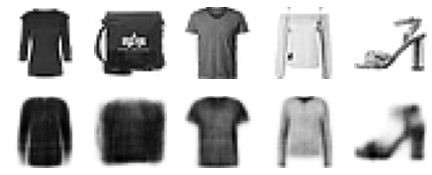

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## 패션 이미지 생성하기

이 변이형 오토인코더를 사용해 패션 의류처럼 보이는 이미지를 생성해보겠습니다.   
해야 할 일은 가우시안 분포에서 랜덤한 코딩을 샘플링하여 디코딩하는 것이 전부입니다.

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

몇 개의 랜덤한 코딩을 생성하고 이를 디코딩하여 결과 이미지를 출력합니다:

Saving figure vae_generated_images_plot


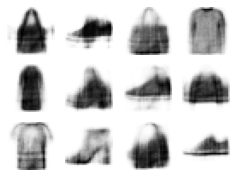

In [ ]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

변이형 오토인코더는 시맨틱 보간(semantic interpolation)을 수행할 수 있습니다.  
(두 이미지가 겹쳐 보이는 것 같은) 픽셀 수준의 보간 대신 코딩 수준에서 두 이미지를 보간할 수 있습니다.   
먼저 두 이미지를 인코더에 통과시켜 얻은 두 코딩을 보간합니다.   
그다음 보간된 코딩을 디코딩하여 최종 이미지를 얻습니다.   
결과는 일반적인 패션 MNIST 이미지처럼 보일 것입니다.   
하지만 원본 이미지 사이에 있는 중간 이미지입니다.   
다음 코드 예제에서 12개의 코딩을 생성하여 이를 3 x 4 격자로 만듭니다.   
텐서플로의 `tf.image.resize()` 함수를 사용해 이 격자를  5 x 7 크기로 바꿉니다.   
기본적으로 `resize()` 함수는 이중 선형 보간(bilinear interpolation)을 수행합니다.   
따라서 늘어난 모든 행과 열이 보간된 코딩을 가집니다.   
그다음 디코더로 이미지를 생성합니다.

시멘틱 보간: 두 이미지의 중간 이미지를 생성한다
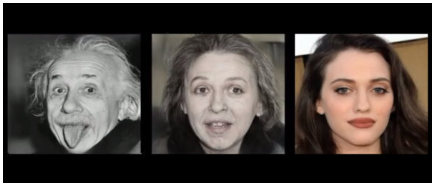

이미지 사이에서 의미 보간을 수행해 보죠:

원본 이미지는 테두리로 표시하고 나머지는 시맨틱 보간한 결과입니다.



Saving figure semantic_interpolation_plot


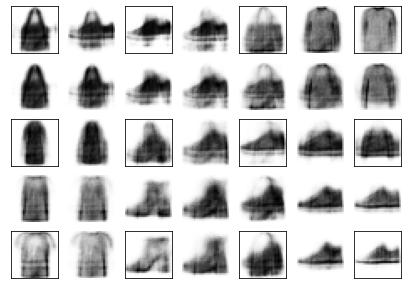

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)